# Assignment 3 - Practical Deep Learning Workshop


#### In this task we will work with the dataset of the Home depot product search relevance competition.
#### Some background: 
In this competition, Home Depot is asking to help them improve their customers' shopping experience by developing a model that can accurately predict the relevance of search results.

Search relevancy is an implicit measure Home Depot uses to gauge how quickly they can get customers to the right products. 

This data set contains a number of products and real customer search terms from Home Depot's website. The challenge is to predict a relevance score for the provided combinations of search terms and products. To create the ground truth labels, Home Depot has crowdsourced the search/product pairs to multiple human raters.
The relevance is a number between 1 (not relevant) to 3 (highly relevant). For example, a search for "AA battery" would be considered highly relevant to a pack of size AA batteries (relevance = 3), mildly relevant to a cordless drill battery (relevance = 2), and not relevant to a snow shovel (relevance = 1).

Each pair was evaluated by at least three human raters. The provided relevance scores are the average value of the ratings. There are three additional things to know about the ratings:
•	The specific instructions given to the raters is provided in relevance_instructions.docx.
•	Raters did not have access to the attributes.
•	Raters had access to product images, while the competition does not include images.


#### Out task here is to predict the relevance for each pair listed in the test set. The test set contains both seen and unseen search terms.


In [1]:
from sklearn.feature_extraction.text import CountVectorizer
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Model, Sequential
from keras.layers import * # Dense, Embedding, LSTM
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
from keras.regularizers import l2
import re

import pandas as pd
import numpy as np
import datetime
import seaborn as sns 
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
%matplotlib inline
 


Using TensorFlow backend.


In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


#### First of all, we'll take a look at the data in each dataset of the input:

train.csv is the training set, contains products, searches, and relevance scores.

In [3]:
train = pd.read_csv('/content/gdrive/My Drive/Colab Notebooks/input/train.csv',encoding='latin1')
train.head()

,id,product_uid,product_title,search_term,relevance
0,2,100001,Simpson Strong-Tie 12-Gauge Angle,angle bracket,3.00
1,3,100001,Simpson Strong-Tie 12-Gauge Angle,l bracket,2.50
2,9,100002,BEHR Premium Textured DeckOver 1-gal. #SC-141 ...,deck over,3.00
3,16,100005,Delta Vero 1-Handle Shower Only Faucet Trim Ki...,rain shower head,2.33
4,17,100005,Delta Vero 1-Handle Shower Only Faucet Trim Ki...,shower only faucet,2.67


test.csv is the test set, contains products and searches. We will need to predict the relevance for these pairs.

In [4]:
test = pd.read_csv('/content/gdrive/My Drive/Colab Notebooks/input/test.csv',encoding='latin1')
test.head()

,id,product_uid,product_title,search_term
0,1,100001,Simpson Strong-Tie 12-Gauge Angle,90 degree bracket
1,4,100001,Simpson Strong-Tie 12-Gauge Angle,metal l brackets
2,5,100001,Simpson Strong-Tie 12-Gauge Angle,simpson sku able
3,6,100001,Simpson Strong-Tie 12-Gauge Angle,simpson strong ties
4,7,100001,Simpson Strong-Tie 12-Gauge Angle,simpson strong tie hcc668


product_descriptions.csv contains a text description of each product. We may join this table to the training or test set via the product_uid.

In [5]:
product_descriptions = pd.read_csv('/content/gdrive/My Drive/Colab Notebooks/input/product_descriptions.csv',encoding='latin1')
product_descriptions.head()

,product_uid,product_description
0,100001,"Not only do angles make joints stronger, they ..."
1,100002,BEHR Premium Textured DECKOVER is an innovativ...
2,100003,Classic architecture meets contemporary design...
3,100004,The Grape Solar 265-Watt Polycrystalline PV So...
4,100005,Update your bathroom with the Delta Vero Singl...


attributes.csv provides extended information about a subset of the products (typically representing detailed technical specifications). Not every product will have attributes.

In [6]:
attributes = pd.read_csv('/content/gdrive/My Drive/Colab Notebooks/input/attributes.csv',encoding='latin1')
attributes.head()

,product_uid,name,value
0,100001.0,Bullet01,Versatile connector for various 90Â° connectio...
1,100001.0,Bullet02,Stronger than angled nailing or screw fastenin...
2,100001.0,Bullet03,Help ensure joints are consistently straight a...
3,100001.0,Bullet04,Dimensions: 3 in. x 3 in. x 1-1/2 in.
4,100001.0,Bullet05,Made from 12-Gauge steel


Data fields:
- id - a unique Id field which represents a (search_term, product_uid) pair
- product_uid - an id for the products
- product_title - the product title
- product_description - the text description of the product (may contain HTML content)
- search_term - the search query
- relevance - the average of the relevance ratings for a given id
- name - an attribute name
- value - the attribute's value


## Preprocessing the data

We would like to have the products' corresponding product description, so we will merge the train and test datasets with the product_description table.

Note: in order to decrease the dimensionality of the text, we will lower the characters.

In [7]:
mergedTrain = pd.merge(train, product_descriptions, how='inner', on='product_uid')
mergedTrain.search_term = mergedTrain.search_term.apply(lambda x: x.lower())
mergedTrain.product_description = mergedTrain.product_description.apply(lambda x: x.lower())

mergedTrain.head()

,id,product_uid,product_title,search_term,relevance,product_description
0,2,100001,Simpson Strong-Tie 12-Gauge Angle,angle bracket,3.00,"not only do angles make joints stronger, they ..."
1,3,100001,Simpson Strong-Tie 12-Gauge Angle,l bracket,2.50,"not only do angles make joints stronger, they ..."
2,9,100002,BEHR Premium Textured DeckOver 1-gal. #SC-141 ...,deck over,3.00,behr premium textured deckover is an innovativ...
3,16,100005,Delta Vero 1-Handle Shower Only Faucet Trim Ki...,rain shower head,2.33,update your bathroom with the delta vero singl...
4,17,100005,Delta Vero 1-Handle Shower Only Faucet Trim Ki...,shower only faucet,2.67,update your bathroom with the delta vero singl...


In [8]:
mergedTest= pd.merge(test, product_descriptions, how='inner', on='product_uid')
mergedTest.search_term = mergedTest.search_term.apply(lambda x: x.lower())
mergedTest.product_description = mergedTest.product_description.apply(lambda x: x.lower())

mergedTest.head()

,id,product_uid,product_title,search_term,product_description
0,1,100001,Simpson Strong-Tie 12-Gauge Angle,90 degree bracket,"not only do angles make joints stronger, they ..."
1,4,100001,Simpson Strong-Tie 12-Gauge Angle,metal l brackets,"not only do angles make joints stronger, they ..."
2,5,100001,Simpson Strong-Tie 12-Gauge Angle,simpson sku able,"not only do angles make joints stronger, they ..."
3,6,100001,Simpson Strong-Tie 12-Gauge Angle,simpson strong ties,"not only do angles make joints stronger, they ..."
4,7,100001,Simpson Strong-Tie 12-Gauge Angle,simpson strong tie hcc668,"not only do angles make joints stronger, they ..."


We convert the product_description and search_term attributes' values to lists of characters.

In [0]:
search_term_chars = []
product_description_chars = []
search_term_chars = mergedTrain.search_term.apply(lambda x: search_term_chars + list(x))
product_description_chars = mergedTrain.product_description.apply(lambda x: product_description_chars + list(x))
search_term_chars = [item for sublist in search_term_chars for item in sublist]
product_description_chars = [item for sublist in product_description_chars for item in sublist]


And then, translate the characters to a unique integer values.

In [0]:
search_term_char_set = sorted(set(search_term_chars))
product_description_char_set = sorted(set(product_description_chars))

# translate from character to number, it's enumerator
search_term_char_to_int = dict((c, i) for i, c in enumerate(search_term_char_set))
search_term_int_to_char = dict((i, c) for i, c in enumerate(search_term_char_set))
product_description_char_to_int = dict((c, i) for i, c in enumerate(product_description_char_set))
product_description_int_to_char = dict((i, c) for i, c in enumerate(product_description_char_set))

In [11]:
# summarize the loaded data
n_chars = len(search_term_chars)
n_vocab = len(search_term_char_set)
print("search_term Total Characters: ", n_chars)
print("search_term Total Vocab: ", n_vocab)

n_chars2 = len(product_description_chars)
n_vocab2 = len(product_description_char_set)
print("product_description Total Characters: ", n_chars2)
print("product_description Total Vocab: ", n_vocab2)

search_term Total Characters:  1407926
search_term Total Vocab:  51
product_description Total Characters:  65598457
product_description Total Vocab:  67


In [12]:
mergedTrain.search_term = mergedTrain.search_term.apply(lambda x: list(x))
mergedTrain.product_description = mergedTrain.product_description.apply(lambda x: list(x))
mergedTrain.head()

,id,product_uid,product_title,search_term,relevance,product_description
0,2,100001,Simpson Strong-Tie 12-Gauge Angle,"[a, n, g, l, e, , b, r, a, c, k, e, t]",3.00,"[n, o, t, , o, n, l, y, , d, o, , a, n, g, ..."
1,3,100001,Simpson Strong-Tie 12-Gauge Angle,"[l, , b, r, a, c, k, e, t]",2.50,"[n, o, t, , o, n, l, y, , d, o, , a, n, g, ..."
2,9,100002,BEHR Premium Textured DeckOver 1-gal. #SC-141 ...,"[d, e, c, k, , o, v, e, r]",3.00,"[b, e, h, r, , p, r, e, m, i, u, m, , t, e, ..."
3,16,100005,Delta Vero 1-Handle Shower Only Faucet Trim Ki...,"[r, a, i, n, , s, h, o, w, e, r, , h, e, a, d]",2.33,"[u, p, d, a, t, e, , y, o, u, r, , b, a, t, ..."
4,17,100005,Delta Vero 1-Handle Shower Only Faucet Trim Ki...,"[s, h, o, w, e, r, , o, n, l, y, , f, a, u, ...",2.67,"[u, p, d, a, t, e, , y, o, u, r, , b, a, t, ..."


In [0]:
def createData(char_to_int, char_arr):
    #seq_length = 100
    dataX = []
    for i in range(0,len(char_arr)):
        dataX.append(char_to_int[char_arr[i]])
    return np.asarray(dataX)

In [14]:
mergedTrain.search_term = mergedTrain.search_term.apply(lambda x: createData(search_term_char_to_int, x))
mergedTrain.product_description = mergedTrain.product_description.apply(lambda x: createData(product_description_char_to_int, x))
mergedTrain.head()


,id,product_uid,product_title,search_term,relevance,product_description
0,2,100001,Simpson Strong-Tie 12-Gauge Angle,"[24, 37, 30, 35, 28, 0, 25, 41, 24, 26, 34, 28...",3.00,"[52, 53, 58, 0, 53, 52, 50, 63, 0, 42, 53, 0, ..."
1,3,100001,Simpson Strong-Tie 12-Gauge Angle,"[35, 0, 25, 41, 24, 26, 34, 28, 43]",2.50,"[52, 53, 58, 0, 53, 52, 50, 63, 0, 42, 53, 0, ..."
2,9,100002,BEHR Premium Textured DeckOver 1-gal. #SC-141 ...,"[27, 28, 26, 34, 0, 38, 45, 28, 41]",3.00,"[40, 43, 46, 56, 0, 54, 56, 43, 51, 47, 59, 51..."
3,16,100005,Delta Vero 1-Handle Shower Only Faucet Trim Ki...,"[41, 24, 32, 37, 0, 42, 31, 38, 46, 28, 41, 0,...",2.33,"[59, 54, 42, 39, 58, 43, 0, 63, 53, 59, 56, 0,..."
4,17,100005,Delta Vero 1-Handle Shower Only Faucet Trim Ki...,"[42, 31, 38, 46, 28, 41, 0, 38, 37, 35, 48, 0,...",2.67,"[59, 54, 42, 39, 58, 43, 0, 63, 53, 59, 56, 0,..."


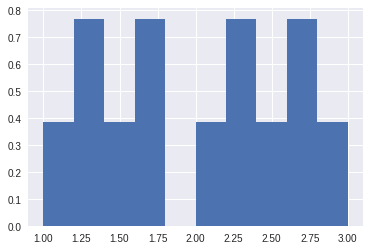

In [15]:
plt.hist(np.unique(mergedTrain.relevance.values),density=True, histtype='bar')
plt.show()

In [16]:
np.unique(mergedTrain.relevance.values).size
          

13

In [17]:
from sklearn import preprocessing

target = mergedTrain['relevance'].values
min_max_scaler = preprocessing.MinMaxScaler()
Y = min_max_scaler.fit_transform(target.reshape(-1, 1))

Y[:5]


array([[1.   ],
       [0.75 ],
       [1.   ],
       [0.665],
       [0.835]])

In [0]:
X1 = mergedTrain['search_term'].values
X2 = mergedTrain['product_description'].values


In [0]:
search_terms_lens = []
for element in mergedTrain['search_term'].values:
    search_terms_lens.append(len(element))
    
product_description_lens = []
for element in mergedTrain['product_description'].values:
    product_description_lens.append(len(element))
    
max_length1 = max(search_terms_lens)
max_length2 = max(product_description_lens)


In [20]:
max_length2

5516

In [0]:
max_length = 75

def padding(seq, length):
    ans = []
    for i in range(0,min(len(seq),length)):
        ans.append(seq[i])
    if len(seq) <= length:
        for i in range(0,length-len(seq)):
            ans.append(0)
    return ans

X1 = np.asarray([padding(x,max_length) for x in X1])
X2 = np.asarray([padding(x,max_length) for x in X2])
X1 = X1.reshape(X1.shape[0],X1.shape[1],1)
X2 = X2.reshape(X2.shape[0],X2.shape[1],1)

In [0]:
X1 = X1.astype(np.float32)
X2 = X2.astype(np.float32)

In [23]:
print(X1.shape)
print(X2.shape)

(74067, 75, 1)
(74067, 75, 1)


In [0]:
st_input = Input(shape=(max_length,1), name='st_input',dtype='float32')
pd_input = Input(shape=(max_length,1), name='pd_input',dtype='float32')


def createModel():
    model = Sequential()
    model.add(LSTM(40))
    model.add(Dense(64, activation='relu'))
    return model

In [25]:
from keras.optimizers import Adadelta

st_model = createModel()
pd_model = createModel()


def createSiameseModel(model1,model2,customLoss):
  out = Lambda(function=lambda x: K.exp(-K.sum(K.abs(x[0]-x[1]), axis=1, keepdims=True)),
                output_shape=lambda x: (x[0][0], 1),
                name='prediction')([model1(st_input), model2(pd_input)])
  siamese_net = Model(input=[st_input,pd_input],output=[out])
  siamese_net.compile(loss=customLoss,optimizer=Adadelta(lr=1.0, rho=0.95,clipnorm=1.20))
  return siamese_net

siamese_net1 = createSiameseModel(st_model,pd_model,'mse')
siamese_net2 = createSiameseModel(st_model,pd_model,'mae')


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=[<tf.Tenso..., outputs=[<tf.Tenso...)`
  # This is added back by InteractiveShellApp.init_path()


In [26]:
st_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 40)                6720      
_________________________________________________________________
dense_1 (Dense)              (None, 64)                2624      
Total params: 9,344
Trainable params: 9,344
Non-trainable params: 0
_________________________________________________________________


In [27]:
siamese_net1.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
st_input (InputLayer)           (None, 75, 1)        0                                            
__________________________________________________________________________________________________
pd_input (InputLayer)           (None, 75, 1)        0                                            
__________________________________________________________________________________________________
sequential_1 (Sequential)       (None, 64)           9344        st_input[0][0]                   
__________________________________________________________________________________________________
sequential_2 (Sequential)       (None, 64)           9344        pd_input[0][0]                   
__________________________________________________________________________________________________
prediction

In [0]:
X1_train,X1_val,X2_train,X2_val,Y_train, Y_val = train_test_split(X1,X2,Y,test_size = 0.2)


In [0]:
from keras.callbacks import *

path = 'gdrive/My Drive/Colab Notebooks'
def set_callbacks(description='run1',patience=15,tb_base_logdir='./logs/'):
    cp = ModelCheckpoint(path + '/best_model_weights_{}.h5'.format(description),save_best_only=True)
    rlop = ReduceLROnPlateau(patience=5)   
    cb = [cp,rlop]
    return cb

In [30]:
start = time.time()
history = siamese_net1.fit([X1_train,X2_train],Y_train,batch_size=1024, epochs=5, verbose=1, validation_data=([X1_val,X2_val],Y_val), callbacks=set_callbacks())
end = time.time()
total_time = end - start

Train on 59253 samples, validate on 14814 samples
Epoch 1/5
59253/59253 [==============================] - 34s 578us/step - loss: 0.1660 - val_loss: 0.0711
Epoch 2/5
59253/59253 [==============================] - 32s 538us/step - loss: 0.0716 - val_loss: 0.0711
Epoch 3/5
59253/59253 [==============================] - 32s 537us/step - loss: 0.0716 - val_loss: 0.0709
Epoch 4/5
59253/59253 [==============================] - 32s 539us/step - loss: 0.0718 - val_loss: 0.0712
Epoch 5/5
59253/59253 [==============================] - 32s 539us/step - loss: 0.0716 - val_loss: 0.0708


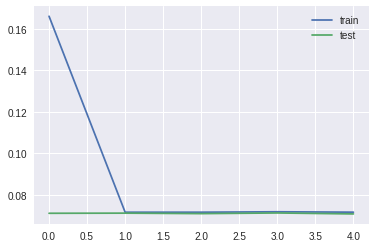

In [31]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()


In [0]:
val_preds = siamese_net1.predict([X1_val,X2_val])
train_preds = siamese_net1.predict([X1_train,X2_train])

In [33]:
val_preds.shape

(14814, 1)

In [34]:
val_preds[:5]

array([[0.69050527],
       [0.69023895],
       [0.6903151 ],
       [0.69023085],
       [0.6902479 ]], dtype=float32)

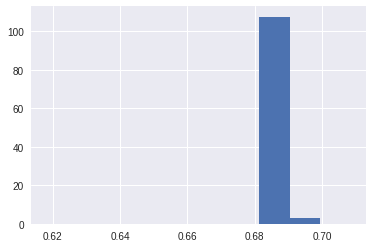

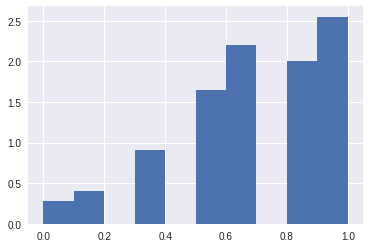

In [35]:

plt.hist(val_preds,density=True, histtype='bar')
plt.show()
plt.hist(Y_val,density=True, histtype='bar')
plt.show()

In [0]:
resultsTable = pd.DataFrame(columns=['model','runtime','TrainRMSE','ValRMSE','TestRMSE','TrainMAE','ValMAE','TestMAE'])

def addToTable(modelName,runtime,train_rmse,val_rmse,test_rmse,train_mae,val_mae,test_mae):
  return resultsTable.append({'model': modelName,'runtime': runtime,'TrainRMSE': train_rmse,'ValRMSE': val_rmse,
                       'TrainMAE': test_rmse,'TrainMAE': train_mae,'ValMAE' :val_mae,'TestMAE': test_mae},ignore_index=True)
  


In [37]:
search_term_chars2 = []
product_description_chars2 = []
search_term_chars2 = mergedTest.search_term.apply(lambda x: search_term_chars2 + list(x))
product_description_chars2 = mergedTest.product_description.apply(lambda x: product_description_chars2 + list(x))
search_term_chars2 = [item for sublist in search_term_chars2 for item in sublist]
product_description_chars2 = [item for sublist in product_description_chars2 for item in sublist]
search_term_char_set2 = sorted(set(search_term_chars2))
product_description_char_set2 = sorted(set(product_description_chars2))

# translate from character to number, it's enumerator
search_term_char_to_int2 = dict((c, i) for i, c in enumerate(search_term_char_set2))
search_term_int_to_char2 = dict((i, c) for i, c in enumerate(search_term_char_set2))
product_description_char_to_int2 = dict((c, i) for i, c in enumerate(product_description_char_set2))
product_description_int_to_char2 = dict((i, c) for i, c in enumerate(product_description_char_set2))

mergedTest.search_term = mergedTest.search_term.apply(lambda x: list(x))
mergedTest.product_description = mergedTest.product_description.apply(lambda x: list(x))

mergedTest.search_term = mergedTest.search_term.apply(lambda x: createData(search_term_char_to_int2, x))
mergedTest.product_description = mergedTest.product_description.apply(lambda x: createData(product_description_char_to_int2, x))
mergedTest.head()

,id,product_uid,product_title,search_term,product_description
0,1,100001,Simpson Strong-Tie 12-Gauge Angle,"[18, 9, 0, 27, 28, 30, 41, 28, 28, 0, 25, 41, ...","[52, 53, 58, 0, 53, 52, 50, 63, 0, 42, 53, 0, ..."
1,4,100001,Simpson Strong-Tie 12-Gauge Angle,"[36, 28, 43, 24, 35, 0, 35, 0, 25, 41, 24, 26,...","[52, 53, 58, 0, 53, 52, 50, 63, 0, 42, 53, 0, ..."
2,5,100001,Simpson Strong-Tie 12-Gauge Angle,"[42, 32, 36, 39, 42, 38, 37, 0, 42, 34, 44, 0,...","[52, 53, 58, 0, 53, 52, 50, 63, 0, 42, 53, 0, ..."
3,6,100001,Simpson Strong-Tie 12-Gauge Angle,"[42, 32, 36, 39, 42, 38, 37, 0, 42, 43, 41, 38...","[52, 53, 58, 0, 53, 52, 50, 63, 0, 42, 53, 0, ..."
4,7,100001,Simpson Strong-Tie 12-Gauge Angle,"[42, 32, 36, 39, 42, 38, 37, 0, 42, 43, 41, 38...","[52, 53, 58, 0, 53, 52, 50, 63, 0, 42, 53, 0, ..."


In [0]:
X1_test = mergedTest.search_term.values
X2_test = mergedTest.product_description.values
X1_test = np.asarray([padding(x,max_length) for x in X1_test])
X2_test = np.asarray([padding(x,max_length) for x in X2_test])
X1_test = X1_test.reshape(X1_test.shape[0],X1_test.shape[1],1)
X2_test = X2_test.reshape(X2_test.shape[0],X2_test.shape[1],1)


In [0]:
test_preds = siamese_net1.predict([X1_test,X2_test])


In [0]:
from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import mean_squared_error as mse


resultsTable = addToTable('CHAR_SiameseNetwork',total_time,mse(train_preds,Y_train),mse(val_preds,Y_val),'-',mae(train_preds,Y_train),mae(val_preds,Y_val),'-')
resultsTable.head()

## ML Benchmark

In [44]:
mergedTrain2 = pd.merge(train, product_descriptions, how='inner', on='product_uid')
mergedTrain2.head()

,id,product_uid,product_title,search_term,relevance,product_description
0,2,100001,Simpson Strong-Tie 12-Gauge Angle,angle bracket,3.00,"Not only do angles make joints stronger, they ..."
1,3,100001,Simpson Strong-Tie 12-Gauge Angle,l bracket,2.50,"Not only do angles make joints stronger, they ..."
2,9,100002,BEHR Premium Textured DeckOver 1-gal. #SC-141 ...,deck over,3.00,BEHR Premium Textured DECKOVER is an innovativ...
3,16,100005,Delta Vero 1-Handle Shower Only Faucet Trim Ki...,rain shower head,2.33,Update your bathroom with the Delta Vero Singl...
4,17,100005,Delta Vero 1-Handle Shower Only Faucet Trim Ki...,shower only faucet,2.67,Update your bathroom with the Delta Vero Singl...


In [0]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer(encoding='latin-1', analyzer='char')
vectorizer.fit(mergedTrain2['search_term'])

mltrain_x, mlval_x, mltrain_y, mlval_y = train_test_split(mergedTrain2['search_term'].values,mergedTrain2['relevance'].values, test_size = 0.2)
train_x_count =  vectorizer.transform(mltrain_x)
val_x_count =  vectorizer.transform(mlval_x)


In [46]:
from sklearn import model_selection, preprocessing, linear_model, naive_bayes, metrics, svm,ensemble

ml = ensemble.RandomForestRegressor()
start_time = time.time()
ml.fit(train_x_count, mltrain_y)
end_time = time.time()
total_time = end_time - start_time

ml_train_preds = ml.predict(train_x_count)
ml_val_preds = ml.predict(val_x_count)
print(ml_val_preds.shape)
resultsTable = addToTable('CHAR_RandomForestBenchmark',total_time,mse(ml_train_preds,mltrain_y),mse(ml_val_preds,mlval_y),'-',mae(ml_train_preds,mltrain_y),mae(ml_val_preds,mlval_y),'-')


/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


(14814,)


In [47]:
resultsTable.head()

,model,runtime,TrainRMSE,ValRMSE,TestRMSE,TrainMAE,ValMAE,TestMAE
0,CHAR_SiameseNetwork,164.869401,0.071411,0.070770,NaN,0.219142,0.217899,-
1,CHAR_RandomForestBenchmark,0.844590,0.156754,0.229464,NaN,0.308950,0.378139,-


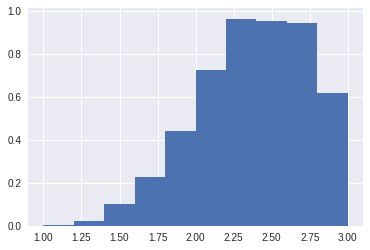

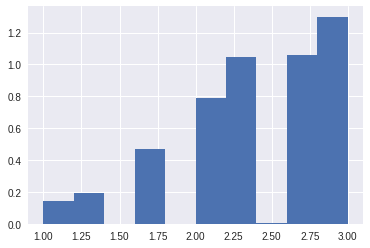

In [48]:
plt.hist(ml_val_preds,density=True, histtype='bar')
plt.show()
plt.hist(mlval_y,density=True, histtype='bar')
plt.show()

## Feature Extraction

In [49]:
path

'gdrive/My Drive/Colab Notebooks'

In [51]:
from keras import backend as K

fe_st_input = Input(shape=(max_length,1), name='st_input',dtype='float32')
fe_pd_input = Input(shape=(max_length,1), name='pd_input',dtype='float32')

input_layer1 = siamese_net1.layers[0].input[0]
input_layer2 = siamese_net1.layers[1].input[0]

fe_st_model = createModel()
fe_pd_model = createModel()

output_layer1 = siamese_net1.layers[3].get_output_at(0)
output_layer2 = siamese_net1.layers[3].get_output_at(1)

output_fn = K.function([st_input, pd_input], [output_layer1, output_layer2])
def extractFeatures(model1,model2,customLoss):
  out = concatenate([model1(fe_st_input), model2(fe_pd_input)])
  siamese_net = Model(input=[fe_st_input,fe_pd_input],output=[out])
  siamese_net.load_weights(path + '/best_model_weights_run1.h5')
  siamese_net.compile(loss=customLoss,optimizer=Adadelta(lr=1.0, rho=0.95,clipnorm=1.20))
  return siamese_net

fe_model = extractFeatures(fe_st_model,fe_pd_model,'mse')


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=[<tf.Tenso..., outputs=[<tf.Tenso...)`


In [0]:
fe_train_features = fe_model.predict([X1_train,X2_train])
fe_val_features = fe_model.predict([X1_val,X2_val])
fe_test_features = fe_model.predict([X1_test,X2_test])

In [55]:

randomForest = ensemble.RandomForestRegressor()
start_time = time.time()
randomForest.fit(fe_train_features, Y_train)
end_time = time.time()
total_time = end_time - start_time


fe_train_preds = randomForest.predict(fe_train_features)
fe_val_preds = randomForest.predict(fe_val_features)
print(ml_val_preds.shape)
resultsTable = addToTable('FE_RandomForest_CHAR',total_time,mse(fe_train_preds,Y_train),mse(fe_val_preds,Y_val),'-',mae(fe_train_preds,Y_train),mae(fe_val_preds,Y_val),'-')


/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  after removing the cwd from sys.path.


In [60]:

linear = linear_model.LinearRegression()
start_time = time.time()
linear.fit(fe_train_features, Y_train)
end_time = time.time()
total_time = end_time - start_time


fe_train_preds2= linear.predict(fe_train_features)
fe_val_preds2 = linear.predict(fe_val_features)
print(ml_val_preds.shape)
resultsTable = addToTable('FE_LinearRegression_CHAR',total_time,mse(fe_train_preds2,Y_train),mse(fe_val_preds2,Y_val),'-',mae(fe_train_preds2,Y_train),mae(fe_val_preds2,Y_val),'-')


(14814,)


In [61]:
resultsTable.head()

,model,runtime,TrainRMSE,ValRMSE,TestRMSE,TrainMAE,ValMAE,TestMAE
0,CHAR_SiameseNetwork,164.869401,0.071411,0.070770,NaN,0.219142,0.217899,-
1,CHAR_RandomForestBenchmark,0.844590,0.156754,0.229464,NaN,0.308950,0.378139,-
2,CHAR_RandomForestBenchmark,25.704365,0.062921,0.067631,NaN,0.203073,0.212757,-
3,FE_SVM_CHAR,0.356916,0.071173,0.071006,NaN,0.218651,0.217673,-


# Word Level Embedding

In [62]:
mergedTrain = pd.merge(train, product_descriptions, how='inner', on='product_uid')
mergedTrain.search_term = mergedTrain.search_term.apply(lambda x: x.lower())
mergedTrain.product_description = mergedTrain.product_description.apply(lambda x: x.lower())

mergedTrain.head()

,id,product_uid,product_title,search_term,relevance,product_description
0,2,100001,Simpson Strong-Tie 12-Gauge Angle,angle bracket,3.00,"not only do angles make joints stronger, they ..."
1,3,100001,Simpson Strong-Tie 12-Gauge Angle,l bracket,2.50,"not only do angles make joints stronger, they ..."
2,9,100002,BEHR Premium Textured DeckOver 1-gal. #SC-141 ...,deck over,3.00,behr premium textured deckover is an innovativ...
3,16,100005,Delta Vero 1-Handle Shower Only Faucet Trim Ki...,rain shower head,2.33,update your bathroom with the delta vero singl...
4,17,100005,Delta Vero 1-Handle Shower Only Faucet Trim Ki...,shower only faucet,2.67,update your bathroom with the delta vero singl...


In [63]:
mergedTest= pd.merge(test, product_descriptions, how='inner', on='product_uid')
mergedTest.search_term = mergedTest.search_term.apply(lambda x: x.lower())
mergedTest.product_description = mergedTest.product_description.apply(lambda x: x.lower())

mergedTest.head()

,id,product_uid,product_title,search_term,product_description
0,1,100001,Simpson Strong-Tie 12-Gauge Angle,90 degree bracket,"not only do angles make joints stronger, they ..."
1,4,100001,Simpson Strong-Tie 12-Gauge Angle,metal l brackets,"not only do angles make joints stronger, they ..."
2,5,100001,Simpson Strong-Tie 12-Gauge Angle,simpson sku able,"not only do angles make joints stronger, they ..."
3,6,100001,Simpson Strong-Tie 12-Gauge Angle,simpson strong ties,"not only do angles make joints stronger, they ..."
4,7,100001,Simpson Strong-Tie 12-Gauge Angle,simpson strong tie hcc668,"not only do angles make joints stronger, they ..."


In [64]:
import nltk
nltk.download('punkt')
from nltk.tokenize import word_tokenize


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [0]:
st_words = []
for term in mergedTrain.search_term.values:
   for word in word_tokenize(term):
      st_words.append(word)
st_word_set = sorted(set(st_words))
st_dict = dict((c, i) for i, c in enumerate(st_word_set))


In [0]:
pd_words = []
for term in mergedTrain.product_description.values:
   for word in word_tokenize(term):
      pd_words.append(word)
pd_word_set = sorted(set(pd_words))
pd_dict = dict((c, i) for i, c in enumerate(pd_word_set))

In [0]:
st_words2 = []
for term in mergedTest.search_term.values:
   for word in word_tokenize(term):
      st_words.append(word)
st_word_set2 = sorted(set(st_words2))
st_dict2 = dict((c, i) for i, c in enumerate(st_word_set2))

pd_words2 = []
for term in mergedTest.product_description.values:
   for word in word_tokenize(term):
      pd_words.append(word)
pd_word_set2 = sorted(set(pd_words2))
pd_dict2 = dict((c, i) for i, c in enumerate(pd_word_set2))


In [67]:
mergedTrain.search_term = mergedTrain.search_term.apply(lambda x: createData(st_dict, word_tokenize(x)))
mergedTrain.product_description = mergedTrain.product_description.apply(lambda x: createData(pd_dict, word_tokenize(x)))

mergedTrain.head()

,id,product_uid,product_title,search_term,relevance,product_description
0,2,100001,Simpson Strong-Tie 12-Gauge Angle,"[1199, 1715]",3.00,"[144772, 147036, 70311, 23139, 133460, 119994,..."
1,3,100001,Simpson Strong-Tie 12-Gauge Angle,"[4486, 1715]",2.50,"[144772, 147036, 70311, 23139, 133460, 119994,..."
2,9,100002,BEHR Premium Textured DeckOver 1-gal. #SC-141 ...,"[2657, 5406]",3.00,"[33028, 162291, 206607, 64260, 118454, 22904, ..."
3,16,100005,Delta Vero 1-Handle Shower Only Faucet Trim Ki...,"[6037, 6714, 3974]",2.33,"[215988, 230394, 31540, 227925, 206720, 65819,..."
4,17,100005,Delta Vero 1-Handle Shower Only Faucet Trim Ki...,"[6714, 5334, 3259]",2.67,"[215988, 230394, 31540, 227925, 206720, 65819,..."


In [0]:
mergedTest.search_term = mergedTest.search_term.apply(lambda x: createData(st_dict2, word_tokenize(x)))
mergedTest.product_description = mergedTest.product_description.apply(lambda x: createData(pd_dict2, word_tokenize(x)))

mergedTest.head()

In [68]:
target = mergedTrain['relevance'].values
min_max_scaler = preprocessing.MinMaxScaler()
Y = min_max_scaler.fit_transform(target.reshape(-1, 1))

Y[:5]


array([[1.   ],
       [0.75 ],
       [1.   ],
       [0.665],
       [0.835]])

In [0]:
X1 = mergedTrain['search_term'].values
X2 = mergedTrain['product_description'].values

search_terms_lens = []
for element in mergedTrain['search_term'].values:
    search_terms_lens.append(len(element))
    
product_description_lens = []
for element in mergedTrain['product_description'].values:
    product_description_lens.append(len(element))
    
max_length1 = max(search_terms_lens)
max_length2 = max(product_description_lens)


In [0]:
max_length = 50

def padding(seq, length):
    ans = []
    for i in range(0,min(len(seq),length)):
        ans.append(seq[i])
    if len(seq) <= length:
        for i in range(0,length-len(seq)):
            ans.append(0)
    return ans

X1 = np.asarray([padding(x,max_length) for x in X1])
X2 = np.asarray([padding(x,max_length) for x in X2])
X1 = X1.reshape(X1.shape[0],X1.shape[1],1)
X2 = X2.reshape(X2.shape[0],X2.shape[1],1)

In [71]:
st_input = Input(shape=(max_length,1), name='st_input')
pd_input = Input(shape=(max_length,1), name='pd_input')


def createModel():
    model = Sequential()
    model.add(LSTM(60))
    model.add(Dense(140, activation='relu'))
    return model
  
st_model3 = createModel()
pd_model3 = createModel()


def createSiameseModel(model1,model2,customLoss):
  out = Lambda(function=lambda x: K.exp(-K.sum(K.abs(x[0]-x[1]), axis=1, keepdims=True)),
                output_shape=lambda x: (x[0][0], 1),
                name='prediction')([model1(st_input), model2(pd_input)])
  siamese_net = Model(input=[st_input,pd_input],output=[out])
  siamese_net.compile(loss=customLoss,optimizer=Adadelta(lr=1.0, rho=0.95,clipnorm=1.20))
  return siamese_net

siamese_net3 = createSiameseModel(st_model3,pd_model3,'mse')
siamese_net4 = createSiameseModel(st_model3,pd_model3,'mae')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:19: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=[<tf.Tenso..., outputs=[<tf.Tenso...)`


In [72]:
siamese_net3.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
st_input (InputLayer)           (None, 50, 1)        0                                            
__________________________________________________________________________________________________
pd_input (InputLayer)           (None, 50, 1)        0                                            
__________________________________________________________________________________________________
sequential_7 (Sequential)       (None, 140)          23420       st_input[0][0]                   
__________________________________________________________________________________________________
sequential_8 (Sequential)       (None, 140)          23420       pd_input[0][0]                   
__________________________________________________________________________________________________
prediction

In [73]:
X1_train,X1_val,X2_train,X2_val,Y_train, Y_val = train_test_split(X1,X2,Y,test_size = 0.2)

start = time.time()
history3 = siamese_net3.fit([X1_train,X2_train],Y_train,batch_size=1024, epochs=5, verbose=1, validation_data=([X1_val,X2_val],Y_val), callbacks=set_callbacks())
end = time.time()
total_time = end - start

Train on 59253 samples, validate on 14814 samples
Epoch 1/5
59253/59253 [==============================] - 47s 786us/step - loss: 0.5479 - val_loss: 0.5473
Epoch 2/5
59253/59253 [==============================] - 44s 747us/step - loss: 0.5473 - val_loss: 0.5468
Epoch 3/5
59253/59253 [==============================] - 44s 745us/step - loss: 0.5469 - val_loss: 0.5464
Epoch 4/5
59253/59253 [==============================] - 45s 763us/step - loss: 0.5463 - val_loss: 0.5455
Epoch 5/5
59253/59253 [==============================] - 45s 757us/step - loss: 0.5412 - val_loss: 0.5361


In [74]:
val_preds = siamese_net3.predict([X1_val,X2_val])
train_preds = siamese_net3.predict([X1_train,X2_train])
test_preds = siamese_net3.predict([X1_test,X2_test])

ValueError: ignored

In [0]:
plt.plot(history3.history['loss'], label='train')
plt.plot(history3.history['val_loss'], label='test')
plt.legend()
plt.show()


In [0]:

predsDF = pd.DataFrame(data = preds)
testDF = pd.DataFrame(data = Y_val)
plt.hist(preds3,density=True, histtype='bar')
plt.show()
plt.hist(Y_val,density=True, histtype='bar')
plt.show()

In [0]:
resultsTable = addToTable('WORD_SiameseNetwork',total_time,mse(train_preds,Y_train),mse(val_preds,Y_val),'-',mae(train_preds,Y_train),mae(val_preds,Y_val),'-')
resultsTable.head()